In [1]:
cd /home/yuchen/pulse2percept

/home/yuchen/pulse2percept


In [2]:
import shapes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pulse2percept as p2p
import skimage
from skimage.measure import label, regionprops, regionprops_table
import math
import string
from statistics import mean
from sklearn.linear_model import LinearRegression
import shapely.geometry as geom
import statsmodels.api as sm 
import pingouin as pg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, MultipleLocator

In [3]:
def curve_length(curve):
    return np.sum(np.sqrt(np.sum((curve[:-1] - curve[1:])**2,axis=1)))

# Analysis

In [4]:
# calculate shapes 
data = shapes.load_shapes("/home/yuchen/shapes/data/shapes.h5", subjects=['12-005','51-009','52-001'],stim_class=None)

result = pd.DataFrame({})
for i in range(len(data)):
    label_img = skimage.measure.label(data['image'][i]>0)
    regions = regionprops(label_img)
    props = regionprops_table(label_img, properties=('centroid',
                                                     'orientation',
                                                     'major_axis_length',
                                                     'minor_axis_length',
                                                     'area',
                                                    'eccentricity',
                                                    'perimeter'))
    df = pd.DataFrame(props).astype('object')
    df.at[0,'centroid-0'] = df.iloc[:, 0].tolist()  # store centroid-x
    df.at[0,'centroid-1'] = df.iloc[:, 1].tolist()  # store centroid-y
    df.at[0,'orientation'] = df.iloc[:, 2].tolist()  # store orientation
    df.at[0,'major_axis_length'] = df.iloc[:, 3].tolist()  # major
    df.at[0,'minor_axis_length'] = df.iloc[:, 4].tolist()  # minor
    df.at[0,'area'] = df.iloc[:, 5].tolist()  # area
    df.at[0,'eccentricity'] = df.iloc[:, 6].tolist()  
    df.at[0,'perimeter'] = df.iloc[:, 7].tolist()  
    result = pd.concat([result, df.iloc[:1,:]],axis=0)

result = result.rename(columns={"area":"size", "orientation":"orientation_new", "eccentricity":"eccentricity_new" })
data = pd.concat([data,result.reset_index(drop=True)],axis=1)
data_copy = data.copy()

In [5]:
data

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,y_center,img_shape,centroid-0,centroid-1,orientation_new,major_axis_length,minor_axis_length,size,eccentricity_new,perimeter
0,12-005,1.50,0.0,145,0.188493,20091028,0.936365,0.0,A2,,...,147.142853,"(384, 512)",[158.04827586206898],[109.8],[0.6821110413302138],[44.32140468284288],[15.558053842857296],[145],[0.93636496430955],[98.31980515339464]
1,12-005,1.50,0.0,174,0.165999,20091028,0.968756,0.0,A2,,...,160.666672,"(384, 512)",[149.17816091954023],[128.98850574712642],[0.32436909928952784],[54.72451414840189],[13.572465848080638],[174],[0.9687563536538782],[114.76955262170047]
2,12-005,1.50,0.0,142,0.173824,20091028,0.871929,0.0,A2,,...,199.000000,"(384, 512)",[199.5],[157.29577464788733],[0.5941795313754955],[36.13555553426097],[17.69314149792771],[142],[0.8719289186956084],[101.31980515339464]
3,12-005,1.50,0.0,137,0.192119,20091028,0.925959,0.0,A2,,...,192.000000,"(384, 512)",[197.3065693430657],[142.98540145985402],[0.2816143003890294],[41.19277618673303],[15.555358942860106],[137],[0.9259592417955648],[94.66295090390226]
4,12-005,1.50,0.0,133,0.217631,20091028,0.992635,0.0,A2,,...,218.000000,"(384, 512)",[220.45864661654136],[140.89473684210526],[0.6099917578573602],[45.09700862618821],[5.463024775523278],[133],[0.992635504425538],[87.6335136523794]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4397,52-001,1.25,0.0,362,0.451952,20100715,0.914627,0.0,F10,,...,192.000000,"(384, 512)",[295.99171270718233],[253.08839779005524],[0.6343384703799624],[37.62394298331629],[15.211331697666775],[362],[0.9146267661985922],[100.32590180780451]
4398,52-001,1.25,0.0,635,0.699985,20100715,0.882533,0.0,F10,,...,192.000000,"(384, 512)",[239.65826771653542],[273.3196850393701],[-1.3482231678237382],[41.991350605844616],[19.746443103711506],[635],[0.8825331170811929],[106.76955262170047]
4399,52-001,1.25,0.0,410,0.545845,20100715,0.850411,0.0,F10,,...,192.000000,"(384, 512)",[252.55609756097562],[252.7439024390244],[0.7627254088575309],[34.86426785440244],[18.342744379040624],[410],[0.8504111243042975],[97.1543289325507]
4400,52-001,1.25,0.0,1389,0.517113,20100715,0.872414,0.0,F10,,...,192.000000,"(384, 512)",[305.3038156947444],[256.3311735061195],[0.549350097745404],[65.74800629470377],[32.13548463428792],[1389],[0.8724141166306661],[183.7228714274745]


In [6]:
%cd /home/yuchen/shapes/shapes

/home/yuchen/shapes/shapes


In [7]:
from distances import dist_across_along, dist_perpendicular_tangential

In [8]:
subj_params = {
    '12-005': {
        'subject_id': 'S2',
        'implant_type_str': 'ArgusII',
        'implant_x': -1896,
        'implant_y': -542,
        'implant_rot': -44,
        'loc_od_x': 15.8,
        'loc_od_y': 1.4,
        'xmin': -30,
        'xmax': 30,
        'ymin': -22.5,
        'ymax': 22.5
    },
    '51-009': {
        'subject_id': 'S3',
        'implant_type_str': 'ArgusII',
        'implant_x': -1203,
        'implant_y': 280,
        'implant_rot': -35,
        'loc_od_x': 15.4,
        'loc_od_y': 1.57,
        'xmin': -32.5,
        'xmax': 32.5,
        'ymin': -24.4,
        'ymax': 24.4
    },
    '52-001': {
        'subject_id': 'S4',
        'implant_type_str': 'ArgusII',
        'implant_x': -1945,
        'implant_y': 469,
        'implant_rot': -34,
        'loc_od_x': 15.8,
        'loc_od_y': 1.51,
        'xmin': -32,
        'xmax': 32,
        'ymin': -24,
        'ymax': 24
    }}

models = {
    '12-005': p2p.models.AxonMapModel(loc_od=(subj_params['12-005']['loc_od_x'], subj_params['12-005']['loc_od_y'])),
    '51-009': p2p.models.AxonMapModel(loc_od=(subj_params['51-009']['loc_od_x'], subj_params['51-009']['loc_od_y'])),
    '52-001': p2p.models.AxonMapModel(loc_od=(subj_params['52-001']['loc_od_x'], subj_params['52-001']['loc_od_y'])),
}
implants = {
    '12-005': p2p.implants.ArgusII(x=subj_params['12-005']['implant_x'], y=subj_params['12-005']['implant_y'], 
                                   rot=subj_params['12-005']['implant_rot']),
    '51-009': p2p.implants.ArgusII(x=subj_params['51-009']['implant_x'], y=subj_params['51-009']['implant_y'], 
                                   rot=subj_params['51-009']['implant_rot']),
    '52-001': p2p.implants.ArgusII(x=subj_params['52-001']['implant_x'], y=subj_params['52-001']['implant_y'], 
                                   rot=subj_params['52-001']['implant_rot'])
}

def too_close(subject, delta_y=200, delta_rot=10):
    """Which electrodes would fall on the other side of the raphe if y or rot were a little off?"""
    implant = implants[subject]
    electrodes = set()
    if delta_y > 0:
        electrodes = set([n for n, e in implant.electrodes.items() if np.abs(e.y) < delta_y])
    if delta_rot > 0:
        for rot in [-delta_rot, delta_rot]:
            new_implant = p2p.implants.ArgusII(x=subj_params[subject]['implant_x'], 
                                            y=subj_params[subject]['implant_y'], 
                                            rot=subj_params[subject]['implant_rot'] + rot)
            # if signbit is true, the y value changed sign by rotating the implant:
            changed = set([n for n, e in new_implant.electrodes.items() if np.signbit(e.y * implant[n].y)])
            electrodes = electrodes.union(changed)
    return list(electrodes)


In [9]:
data = data_copy.copy()

data_double = data[(data['electrode2'] != str())].reset_index(drop=True)
data_single = data[(data['electrode2'] == str())].reset_index(drop=True)
data_single['stim_class'] ='SingleElectrode'
df = data_single[['subject', 'electrode1', 'freq', 'amp1']].drop_duplicates().reset_index(drop=True)
mo = 0
de = 0
lst = []
lst_size = []
lst_major = []
lst_minor = []
lst_eccentricity = []
lst_orientation = []
lst_perimeter = []

for i in range(len(df)):
    df_temp = data_single[(data_single['subject'] == df.subject[i]) & (data_single['electrode1'] == df.electrode1[i]) & (data_single['freq'] == df.freq[i]) & (data_single['amp1'] == df.amp1[i])].reset_index(drop=True)
    ratio = len(df_temp[df_temp['num_regions']>1]) /len(df_temp)
    
    for row in range(len(df_temp)):
        df_temp['size'][row] = sum(df_temp['size'][row])
        df_temp['major_axis_length'][row] = sum(df_temp['major_axis_length'][row])
        df_temp['minor_axis_length'][row] = sum(df_temp['minor_axis_length'][row])
        df_temp['perimeter'][row] = sum(df_temp['perimeter'][row])
        df_temp['orientation_new'][row] = sum(df_temp['orientation_new'][row])
        
    
    count_length = len(df_temp)
    
    lst_size.append(df_temp['size'].sum()/count_length)
    lst_major.append(df_temp['major_axis_length'].sum()/count_length)
    lst_minor.append(df_temp['minor_axis_length'].sum()/count_length)
    lst_perimeter.append(df_temp['perimeter'].sum()/count_length)
    lst_orientation.append(df_temp['orientation_new'].sum()/count_length)
    
        
df['avg_size'] = lst_size
df['avg_major'] = lst_major
df['avg_minor'] = lst_minor
df['avg_perimeter'] = lst_perimeter
df['avg_orientation'] = lst_orientation


data_single = df.copy()

subject = ['12-005', '51-009', '52-001']
df = pd.DataFrame({})

for subj in subject:
    lst_e = []
    lst_dtf = []
    
    s2 = shapes.subject_params[subj]
    implant,model = shapes.model_from_params(s2)
    for i in string.ascii_uppercase[0:6]: 
        for j in range(1,11):
            electrode = i + str(j)
            lst_e.append(electrode)
            lst_dtf.append(math.sqrt(implant[electrode].x**2 +implant[electrode].y**2 ))
            
    df_o = pd.DataFrame(lst_e, columns=['electrode1'])
    df_o['distance_to_fovea'] = lst_dtf
    
    if subj == '12-005':
        lst_d = [0,0,0,2,7,7,0,0,5,0,
                0,0,4,11,13,15,15,3,7,4,
                0,0,15,16,17,17,19,16,9,4,
                0,0,16,19,15,17,22,25,13,10,
                0,0,8,15,14,13,17,23,14,2,
                0,0,10,15,13,12,9,11,5]
        lst_e = lst_e[:-1]
    elif subj == '51-009':
        lst_e = ['F1','F2','F3','F4','F5','F6',
               'E1','E2','E3','E4','E5','E6',
               'D1','D2','D3','D4','D5','D6','D7',
               'C1','C2','C3','C4','C5','C6','C7','C8',
               'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10', 
               'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        lst_d = [0] * len(lst_e)
    else:
        lst_e = ['F1','F2','F4','F5','F6','F7','F8','F9','F10',
               'E1','E2','E3','E4','E5','E6','E7','E8','E9','E10', 
               'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 
               'C3','C4','C5','C6','C7','C8','C9','C10', 
               'B1','B3','B4','B5','B6','B7','B8','B9','B10', 
               'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        lst_d = [0] * len(lst_e)
    lst_s = [subj] * len(lst_e)
    
    df_o = df_o[df_o.electrode1.isin(lst_e)]
    df_o['distance_to_implant'] = lst_d
    df_o['subject'] = lst_s
    df = pd.concat([df, df_o])
data_single = data_single.merge(df, how = 'inner', on = ['electrode1','subject'])


index_lst = []
for i in range(len(data_double)):
    if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode1[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
        if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode2[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
            index_lst.append(i)

### size

In [10]:
df_AllSub = pd.DataFrame()

condition_list = [0]  
label_list = ['MultiElectrode']
for condition in condition_list:
    for label in range(1):
        data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
        data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
        lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
        lst = lst.drop_duplicates().reset_index(drop=True)

        double = []
        single_dtf = []
        single_dti = []
        lst_subject = []
        
        distance = []
        amp = []
        freq = []
        electrode = []
        across = []
        along = []
        for i in range(len(lst)):
            electrode1 = lst.electrode1[i]
            electrode2 = lst.electrode2[i]
            temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
            close_electrode = []
            
            if not temp1.empty and not temp2.empty and not double_temp.empty:
                if electrode1 not in close_electrode and electrode2 not in close_electrode:
                    
                    count = 0
                    for j in range(len(double_temp)):
                        count += sum(double_temp['size'][j])
                    double.append(count/len(double_temp))
                    single_dtf.append((temp1.distance_to_fovea[0] + temp2.distance_to_fovea[0])/2)
                    single_dti.append((temp1.distance_to_implant[0] + temp2.distance_to_implant[0])/2)
                    lst_subject.append(temp1.subject[0])

                    subject = shapes.subject_params[temp1.subject[0]]
                    implant,model = shapes.model_from_params(subject)

                    arr = dist_across_along([electrode1], [electrode2], implant, model,strategy='radial')
                    
                    e1_x = implant[electrode1].x
                    e1_y = implant[electrode1].y
                    e2_x = implant[electrode2].x
                    e2_y = implant[electrode2].y

                    distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
                
                    across.append(arr[0,1])
                    along.append(arr[0,2])

                    amp.append(lst.amp1[i])
                    freq.append(lst.freq[i])

        df_investigate = pd.DataFrame({
                                       'double':double, 
                                       'freq':freq,
                                       'amp':amp,
                                       'single_dtf':single_dtf,
                                       'single_dti':single_dti,
            'distance':distance,
                                        'across':across,
                                        'along':along,
                                       'subject':lst_subject
                                      })
        
        df_AllSub = df_investigate.copy()
        
            
        temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) &
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
        
        temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
        df = pd.DataFrame({})
        for subj in temp.subject:
            df_investigate_temp = df_investigate[df_investigate.subject == subj]
            df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['double']
            filename = subj + label_list[label]
            df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
            df = pd.concat([df, df_investigate_temp])
        df_investigate = df.copy()
        filename = label_list[label]
        df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

In [11]:
copy = df_investigate.copy()
df_AllSub=df_investigate.copy()

df_s = pd.DataFrame({})
for subj in ['12-005','51-009','52-001','All']:
    if subj=='All':
        df_t = df_AllSub.copy()
    else:   
        df_t = copy[copy.subject == subj]
    df_t['amp'] = (df_t['amp'] - df_t['amp'].mean()) / df_t['amp'].std()
    df_t['single_dti'] = (df_t['single_dti'] - df_t['single_dti'].mean()) / df_t['single_dti'].std()
    df_t['single_dtf'] = (df_t['single_dtf'] - df_t['single_dtf'].mean()) / df_t['single_dtf'].std()
    df_t['across'] = (df_t['across'] - df_t['across'].mean()) / df_t['across'].std()
    df_t['along'] = (df_t['along'] - df_t['along'].mean()) / df_t['along'].std()
    
    if subj == 'All':  
        df_AllSub = df_t.copy()
    else:
        df_s = pd.concat([df_s, df_t])
        df_s = df_s.fillna(0)
        
df_investigate = df_s.copy().reset_index(drop=True)

In [12]:
df_AllSub = df_AllSub[(df_AllSub.amp <3) & (df_AllSub.across < 3) & (df_AllSub.along < 3)].reset_index(drop=True)
df_investigate = df_investigate[(df_investigate.amp <3) & (df_investigate.across < 3) 
                                & (df_investigate.along < 3)].reset_index(drop=True)

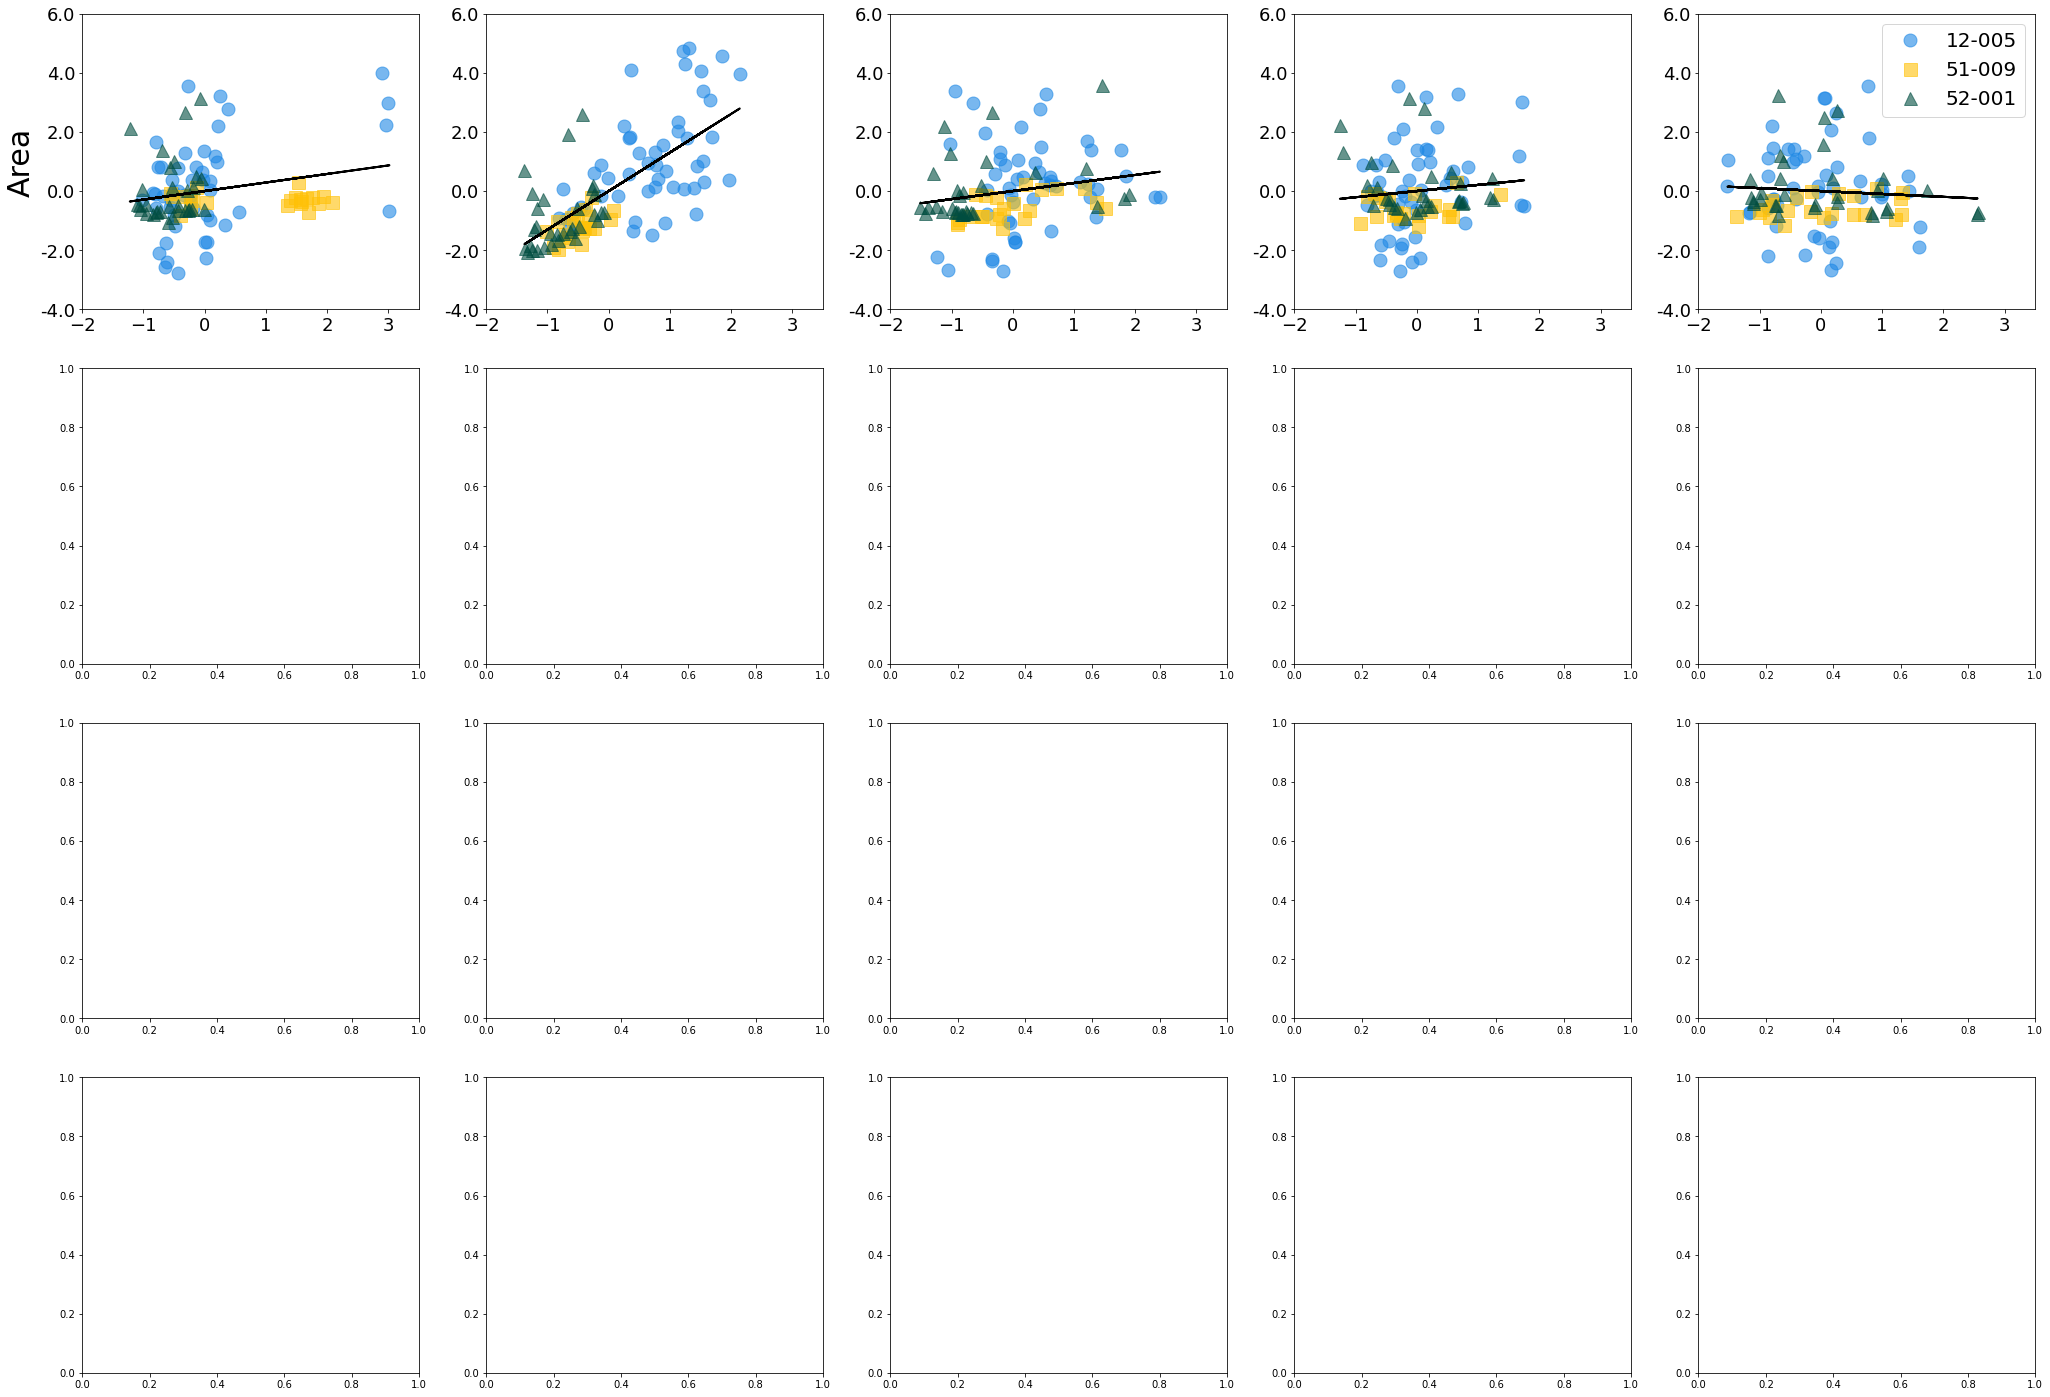

In [13]:
fig, axs= plt.subplots(nrows = 4, ncols=5, figsize=(35, 25))
column_lst = ['amp','single_dti', 'single_dtf','across', 'along']
name_lst = ['Amplitude','Electrode-Retina Distance', 'Electrode-Fovea Distance','Between-Axon Distance','Along-Axon Distance']
for dv in range(5):
    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[['double']])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    y = df_AllSub[['double']]-y_predicted

    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[column_lst[dv]])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    x = df_AllSub[column_lst[dv]]-y_predicted
    df_AllSub['x'] = x
    df_AllSub['y'] = y
    subject = ['12-005','51-009','52-001']
    marker_lst = ['o','s','^']
    color_lst = ['#1E88E5', '#FFC107','#004D40']
    for i in range(len(subject)):
        temp = df_AllSub[df_AllSub.subject == subject[i]]
        axs[0,dv].plot(temp['x'],temp['y'],marker_lst[i], color=color_lst[i],alpha=0.6,markersize=13)
    axs[0,-1].legend(subject, loc='upper right',prop={'size': 20})
    reg = LinearRegression().fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    y_pred = reg.predict(np.array(x).reshape(-1,1))
    axs[0,dv].plot(x, y_pred,'-', color="black",linewidth=2)
    axs[0,dv].set(ylim=(-4,6), xlim=(-2,3.5))
    axs[0,0].set( ylabel = 'Area')
    axs[0,dv].tick_params(axis='both',  labelsize=18)
    
    axs[0,dv].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    for item in ([axs[0,dv].xaxis.label, axs[0,dv].yaxis.label]):
        item.set_fontsize(30)


In [14]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == '12-005':
        X = temp[['amp','single_dtf','single_dti','across','along']]
    elif subj == 'AllSubjects':
        temp = df_AllSub.copy()
        X = temp[['amp','single_dtf','single_dti','across','along']]
        
    else:
        X = temp[['amp','single_dtf','across','along']]
    y = temp.double
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient')
    [ print(round(x,5), end='\n') for x in est2.params.tolist()[1:]]
    coef = [ round(x,5) for x in est2.params.tolist()[1:]]
    
    print('\npvalues')
    [ print(round(x,5), end='\n') for x in est2.pvalues.tolist()[1:]]
    p = [ round(x,5) for x in est2.pvalues.tolist()[1:]]
    
    print('\nvariance inflation factor: ')
    print([[X.columns[i],variance_inflation_factor(X.values, i)]
                          for i in range(len(X.columns))])
    print('\npartial correlation: ')
    X['double'] = temp['double']
    [print(round(X.pcorr()['double'][i].tolist(), 6), end='\n') for i in X.pcorr()[:-1]]
    pcor = [round(X.pcorr()['double'][i].tolist(), 6) for i in X.pcorr()[:-1]]
    
    print(' ')
    
    if subj == 'AllSubjects' or subj == '12-005':
        pcor[1],pcor[2] = pcor[2],pcor[1]
        coef[1],coef[2] = coef[2],coef[1]
        p[1],p[2] = p[2],p[1]
    
    for idx in range(len(p)):
        print('$', end = '')
        x = f'{coef[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        if p[idx]<0.001: print('***', end = ' ')
        elif p[idx]<0.01: print('**', end = ' ')
        elif p[idx]<0.05: print('*', end = ' ')
        else: print('', end = ' ')
        print('& $', end = '')
        x = f'{pcor[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        print()


subject: 12-005
                            OLS Regression Results                            
Dep. Variable:                 double   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     4.779
Date:                Tue, 18 Jul 2023   Prob (F-statistic):            0.00162
Time:                        14:11:49   Log-Likelihood:                -78.093
No. Observations:                  46   AIC:                             168.2
Df Residuals:                      40   BIC:                             179.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2116      0.284    

### major_axis_length

In [15]:
df_AllSub = pd.DataFrame()

condition_list = [0]  
label_list = ['SpatialSummation','MultiElectrode']
label_list = ['MultiElectrode']
for condition in condition_list:
    for label in range(1):
        data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
        data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
        lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
        lst = lst.drop_duplicates().reset_index(drop=True)

        double = []
        single_dtf = []
        single_dti = []
        lst_subject = []
        
        distance = []
        amp = []
        freq = []
        electrode = []
        across = []
        along = []
        for i in range(len(lst)):
            electrode1 = lst.electrode1[i]
            electrode2 = lst.electrode2[i]
            temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
            close_electrode = []
            
            if not temp1.empty and not temp2.empty and not double_temp.empty:
                if electrode1 not in close_electrode and electrode2 not in close_electrode:
                    
                    count = 0
                    for j in range(len(double_temp)):
                        count += sum(double_temp['major_axis_length'][j])
                    double.append(count/len(double_temp))
                    single_dtf.append((temp1.distance_to_fovea[0] + temp2.distance_to_fovea[0])/2)
                    single_dti.append((temp1.distance_to_implant[0] + temp2.distance_to_implant[0])/2)
                    lst_subject.append(temp1.subject[0])

                    subject = shapes.subject_params[temp1.subject[0]]
                    implant,model = shapes.model_from_params(subject)

                    arr = dist_across_along([electrode1], [electrode2], implant, model,strategy='radial')
                    across.append(arr[0,1])
                    along.append(arr[0,2])
                    
                    e1_x = implant[electrode1].x
                    e1_y = implant[electrode1].y
                    e2_x = implant[electrode2].x
                    e2_y = implant[electrode2].y

                    distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
                    

                    amp.append(lst.amp1[i])
                    freq.append(lst.freq[i])

        df_investigate = pd.DataFrame({
                                       'double':double, 
                                       'freq':freq,
                                       'amp':amp,
                                       'single_dtf':single_dtf,
                                       'single_dti':single_dti,
            'distance':distance,
                                        'across':across,
                                        'along':along,
                                       'subject':lst_subject
                                      })
        
        df_AllSub = df_investigate.copy()
        

        temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) & 
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
        temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
        df = pd.DataFrame({})
        for subj in temp.subject:
            df_investigate_temp = df_investigate[df_investigate.subject == subj]
            df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['double']
            filename = subj + label_list[label]
            df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
            df = pd.concat([df, df_investigate_temp])
        df_investigate = df.copy()
        filename = label_list[label]
        df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

In [16]:
copy = df_investigate.copy()
df_AllSub = df_investigate.copy()

df_s = pd.DataFrame({})
for subj in ['12-005','51-009','52-001','All']:
    if subj=='All':
        df_t = df_AllSub.copy()
    else:   
        df_t = copy[copy.subject == subj]
    df_t['amp'] = (df_t['amp'] - df_t['amp'].mean()) / df_t['amp'].std()
    df_t['single_dti'] = (df_t['single_dti'] - df_t['single_dti'].mean()) / df_t['single_dti'].std()
    df_t['single_dtf'] = (df_t['single_dtf'] - df_t['single_dtf'].mean()) / df_t['single_dtf'].std()
    df_t['distance'] = (df_t['distance'] - df_t['distance'].mean()) / df_t['distance'].std()
    
    df_t['across'] = (df_t['across'] - df_t['across'].mean()) / df_t['across'].std()
    df_t['along'] = (df_t['along'] - df_t['along'].mean()) / df_t['along'].std()
    
    if subj == 'All':  
        df_AllSub = df_t.copy()
    else:
        df_s = pd.concat([df_s, df_t])
        df_s = df_s.fillna(0)
        
df_investigate = df_s.copy().reset_index(drop=True)

In [17]:
df_AllSub = df_AllSub[(df_AllSub.amp <3) & (df_AllSub.across < 3) & (df_AllSub.along < 3)].reset_index(drop=True)
df_investigate = df_investigate[(df_investigate.amp <3) & (df_investigate.across < 3) 
                                & (df_investigate.along < 3)].reset_index(drop=True)

In [18]:
column_lst = ['amp','single_dti', 'single_dtf','across', 'along']
name_lst = ['Amplitude','Electrode-Retina Distance', 'Electrode-Fovea Distance','Between-Axon Distance','Along-Axon Distance']
for dv in range(5):
    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[['double']])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    y = df_AllSub[['double']]-y_predicted

    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[column_lst[dv]])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    x = df_AllSub[column_lst[dv]]-y_predicted
    df_AllSub['x'] = x
    df_AllSub['y'] = y
    subject = ['12-005','51-009','52-001']
    marker_lst = ['o','s','^']
    color_lst = ['#1E88E5', '#FFC107','#004D40']
    for i in range(len(subject)):
        temp = df_AllSub[df_AllSub.subject == subject[i]]
        axs[2, dv].plot(temp['x'],temp['y'],marker_lst[i], color=color_lst[i],alpha=0.6,markersize=13)
    reg = LinearRegression().fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    y_pred = reg.predict(np.array(x).reshape(-1,1))
    axs[2, dv].plot(x, y_pred,'-', color="black",linewidth=2)
    axs[2, dv].set(ylim=(-0.75,0.9),xlim=(-2,3.5))
    axs[2, 0].set(ylabel = 'Major Axis Length')
    axs[2, dv].tick_params(axis='both',  labelsize=18)
    
    axs[2, dv].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    for item in ([axs[2, dv].xaxis.label, axs[2, dv].yaxis.label]):
        item.set_fontsize(30)


In [19]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == '12-005':
        X = temp[['amp','single_dtf','single_dti','across','along']]
    elif subj == 'AllSubjects':
        temp = df_AllSub.copy()
        
        X = temp[['amp','single_dtf','single_dti','across','along']]
    else:
        X = temp[['amp','single_dtf','across','along']]
    y = temp.double
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient')
    [ print(round(x,5), end='\n') for x in est2.params.tolist()[1:]]
    coef = [ round(x,5) for x in est2.params.tolist()[1:]]
    
    print('\npvalues')
    [ print(round(x,5), end='\n') for x in est2.pvalues.tolist()[1:]]
    p = [ round(x,5) for x in est2.pvalues.tolist()[1:]]
    
    print('\nvariance inflation factor: ')
    print([[X.columns[i],variance_inflation_factor(X.values, i)]
                          for i in range(len(X.columns))])
    print('\npartial correlation: ')
    X['double'] = temp['double']
    [print(round(X.pcorr()['double'][i].tolist(), 6), end='\n') for i in X.pcorr()[:-1]]
    pcor = [round(X.pcorr()['double'][i].tolist(), 6) for i in X.pcorr()[:-1]]
    
    print(' ')
    
    if subj == 'AllSubjects' or subj == '12-005':
        pcor[1],pcor[2] = pcor[2],pcor[1]
        coef[1],coef[2] = coef[2],coef[1]
        p[1],p[2] = p[2],p[1]
    
    for idx in range(len(p)):
        print('$', end = '')
        x = f'{coef[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        if p[idx]<0.001: print('***', end = ' ')
        elif p[idx]<0.01: print('**', end = ' ')
        elif p[idx]<0.05: print('*', end = ' ')
        else: print('', end = ' ')
        print('& $', end = '')
        x = f'{pcor[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        print()

    

subject: 12-005
                            OLS Regression Results                            
Dep. Variable:                 double   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     3.444
Date:                Tue, 18 Jul 2023   Prob (F-statistic):             0.0111
Time:                        14:12:44   Log-Likelihood:                 16.050
No. Observations:                  46   AIC:                            -20.10
Df Residuals:                      40   BIC:                            -9.127
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7376      0.037    

### minor_axis_length

In [20]:
df_AllSub = pd.DataFrame()

condition_list = [0]  
label_list = ['MultiElectrode']
for condition in condition_list:
    for label in range(1):
        data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
        data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
        lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
        lst = lst.drop_duplicates().reset_index(drop=True)

        double = []
        single_dtf = []
        single_dti = []
        lst_subject = []
        
        distance = []
        amp = []
        freq = []
        electrode = []
        across = []
        along = []
        for i in range(len(lst)):
            electrode1 = lst.electrode1[i]
            electrode2 = lst.electrode2[i]
            temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
            close_electrode = []
            
            if not temp1.empty and not temp2.empty and not double_temp.empty:
                if electrode1 not in close_electrode and electrode2 not in close_electrode:
                    
                    count = 0
                    for j in range(len(double_temp)):
                        count += sum(double_temp['minor_axis_length'][j])
                    double.append(count/len(double_temp))
                    single_dtf.append((temp1.distance_to_fovea[0] + temp2.distance_to_fovea[0])/2)
                    single_dti.append((temp1.distance_to_implant[0] + temp2.distance_to_implant[0])/2)
                    lst_subject.append(temp1.subject[0])

                    subject = shapes.subject_params[temp1.subject[0]]
                    implant,model = shapes.model_from_params(subject)

                    arr = dist_across_along([electrode1], [electrode2], implant, model,strategy='radial')
                    across.append(arr[0,1])
                    along.append(arr[0,2])

                    e1_x = implant[electrode1].x
                    e1_y = implant[electrode1].y
                    e2_x = implant[electrode2].x
                    e2_y = implant[electrode2].y

                    distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))

                    amp.append(lst.amp1[i])
                    freq.append(lst.freq[i])

        df_investigate = pd.DataFrame({
                                       'double':double, 
                                       'freq':freq,
                                       'amp':amp,
                                       'single_dtf':single_dtf,
                                       'single_dti':single_dti,
                                        'across':across,
                                        'along':along,
            'distance':distance,
                                       'subject':lst_subject
                                      })

        temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) & 
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
        temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
        df = pd.DataFrame({})
        for subj in temp.subject:
            df_investigate_temp = df_investigate[df_investigate.subject == subj]
            df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['double']
            filename = subj + label_list[label]
            df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
            df = pd.concat([df, df_investigate_temp])
        df_investigate = df.copy()
        filename = label_list[label]
        df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

In [21]:
copy = df_investigate.copy()
df_AllSub = df_investigate.copy()

df_s = pd.DataFrame({})
for subj in ['12-005','51-009','52-001','All']:
    if subj=='All':
        df_t = df_AllSub.copy()
    else:   
        df_t = copy[copy.subject == subj]
    df_t['amp'] = (df_t['amp'] - df_t['amp'].mean()) / df_t['amp'].std()
    df_t['single_dti'] = (df_t['single_dti'] - df_t['single_dti'].mean()) / df_t['single_dti'].std()
    df_t['single_dtf'] = (df_t['single_dtf'] - df_t['single_dtf'].mean()) / df_t['single_dtf'].std()
    df_t['distance'] = (df_t['distance'] - df_t['distance'].mean()) / df_t['distance'].std()
    
    df_t['across'] = (df_t['across'] - df_t['across'].mean()) / df_t['across'].std()
    df_t['along'] = (df_t['along'] - df_t['along'].mean()) / df_t['along'].std()
    
    if subj == 'All':  
        df_AllSub = df_t.copy()
    else:
        df_s = pd.concat([df_s, df_t])
        df_s = df_s.fillna(0)
        
df_investigate = df_s.copy().reset_index(drop=True)

In [22]:
df_AllSub = df_AllSub[(df_AllSub.amp <3) & (df_AllSub.across < 3) & (df_AllSub.along < 3)].reset_index(drop=True)
df_investigate = df_investigate[(df_investigate.amp <3) & (df_investigate.across < 3) 
                                & (df_investigate.along < 3)].reset_index(drop=True)

In [23]:
column_lst = ['amp','single_dti', 'single_dtf','across', 'along']
name_lst = ['Amplitude','Electrode-Retina Distance', 'Electrode-Fovea Distance','Between-Axon Distance','Along-Axon Distance']
for dv in range(5):
    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[['double']])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    y = df_AllSub[['double']]-y_predicted

    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[column_lst[dv]])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    x = df_AllSub[column_lst[dv]]-y_predicted
    df_AllSub['x'] = x
    df_AllSub['y'] = y
    subject = ['12-005','51-009','52-001']
    marker_lst = ['o','s','^']
    color_lst = ['#1E88E5', '#FFC107','#004D40']
    for i in range(len(subject)):
        temp = df_AllSub[df_AllSub.subject == subject[i]]
        axs[3, dv].plot(temp['x'],temp['y'],marker_lst[i], color=color_lst[i],alpha=0.6,markersize=13)
    reg = LinearRegression().fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    y_pred = reg.predict(np.array(x).reshape(-1,1))
    axs[3, dv].plot(x, y_pred,'-', color="black",linewidth=2)
    axs[3, dv].set(xlabel = name_lst[dv],ylim=(-1.5,2.3),xlim=(-2,3.5))
    axs[3, 0].set(ylabel = 'Minor Axis Length')
    axs[3, dv].tick_params(axis='both',  labelsize=18)
    axs[3, dv].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    for item in ([axs[3, dv].xaxis.label, axs[3, dv].yaxis.label]):
        item.set_fontsize(30)


In [24]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == '12-005':
        X = temp[['amp','single_dtf','single_dti','across','along']]
    elif subj == 'AllSubjects':
        temp = df_AllSub.copy()
        X = temp[['amp','single_dtf','single_dti','across','along']]
    else:
        X = temp[['amp','single_dtf','across','along']]
    y = temp.double
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient')
    [ print(round(x,5), end='\n') for x in est2.params.tolist()[1:]]
    coef = [ round(x,5) for x in est2.params.tolist()[1:]]
    
    print('\npvalues')
    [ print(round(x,5), end='\n') for x in est2.pvalues.tolist()[1:]]
    p = [ round(x,5) for x in est2.pvalues.tolist()[1:]]
    
    print('\nvariance inflation factor: ')
    print([[X.columns[i],variance_inflation_factor(X.values, i)]
                          for i in range(len(X.columns))])
    print('\npartial correlation: ')
    X['double'] = temp['double']
    [print(round(X.pcorr()['double'][i].tolist(), 6), end='\n') for i in X.pcorr()[:-1]]
    pcor = [round(X.pcorr()['double'][i].tolist(), 6) for i in X.pcorr()[:-1]]
    
    print(' ')
    
    if subj == 'AllSubjects' or subj == '12-005':
        pcor[1],pcor[2] = pcor[2],pcor[1]
        coef[1],coef[2] = coef[2],coef[1]
        p[1],p[2] = p[2],p[1]
    
    for idx in range(len(p)):
        print('$', end = '')
        x = f'{coef[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        if p[idx]<0.001: print('***', end = ' ')
        elif p[idx]<0.01: print('**', end = ' ')
        elif p[idx]<0.05: print('*', end = ' ')
        else: print('', end = ' ')
        print('& $', end = '')
        x = f'{pcor[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        print()
    

subject: 12-005
                            OLS Regression Results                            
Dep. Variable:                 double   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     7.141
Date:                Tue, 18 Jul 2023   Prob (F-statistic):           7.42e-05
Time:                        14:13:37   Log-Likelihood:                -18.303
No. Observations:                  46   AIC:                             48.61
Df Residuals:                      40   BIC:                             59.58
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5180      0.077    

### perimeter

In [25]:
df_AllSub = pd.DataFrame()

condition_list = [0]  
label_list = ['MultiElectrode']
for condition in condition_list:
    for label in range(1):
        data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
        data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
        lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
        lst = lst.drop_duplicates().reset_index(drop=True)

        double = []
        single_dtf = []
        single_dti = []
        lst_subject = []
        
        distance = []
        amp = []
        freq = []
        electrode = []
        across = []
        along = []
        for i in range(len(lst)):
            electrode1 = lst.electrode1[i]
            electrode2 = lst.electrode2[i]
            temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
            close_electrode = too_close(temp1.subject[0], delta_y=100, delta_rot=5)
            close_electrode = []
            
            if not temp1.empty and not temp2.empty and not double_temp.empty:
                if electrode1 not in close_electrode and electrode2 not in close_electrode:
                    
                    count = 0
                    for j in range(len(double_temp)):
                        count += sum(double_temp['perimeter'][j])
                    double.append(count/len(double_temp))
                    single_dtf.append((temp1.distance_to_fovea[0] + temp2.distance_to_fovea[0])/2)
                    single_dti.append((temp1.distance_to_implant[0] + temp2.distance_to_implant[0])/2)
                    lst_subject.append(temp1.subject[0])

                    subject = shapes.subject_params[temp1.subject[0]]
                    implant,model = shapes.model_from_params(subject)
                    
                    e1_x = implant[electrode1].x
                    e1_y = implant[electrode1].y
                    e2_x = implant[electrode2].x
                    e2_y = implant[electrode2].y

                    distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))

                    arr = dist_across_along([electrode1], [electrode2], implant, model,strategy='radial')
                    across.append(arr[0,1])
                    along.append(arr[0,2])

                    amp.append(lst.amp1[i])
                    freq.append(lst.freq[i])

        df_investigate = pd.DataFrame({
                                       'double':double, 
                                       'freq':freq,
                                       'amp':amp,
                                       'single_dtf':single_dtf,
                                       'single_dti':single_dti,
                                        'across':across,
                                        'along':along,
            'distance':distance,
                                       'subject':lst_subject
                                      })
        
        temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) & 
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
        temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
        df = pd.DataFrame({})
        for subj in temp.subject:
            df_investigate_temp = df_investigate[df_investigate.subject == subj]
            df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['double']
            filename = subj + label_list[label]
            df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
            df = pd.concat([df, df_investigate_temp])
        df_investigate = df.copy()
        filename = label_list[label]
        df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

In [26]:
copy = df_investigate.copy()
df_AllSub = df_investigate.copy()

df_s = pd.DataFrame({})
for subj in ['12-005','51-009','52-001','All']:
    if subj=='All':
        df_t = df_AllSub.copy()
    else:   
        df_t = copy[copy.subject == subj]
    df_t['amp'] = (df_t['amp'] - df_t['amp'].mean()) / df_t['amp'].std()
    df_t['single_dti'] = (df_t['single_dti'] - df_t['single_dti'].mean()) / df_t['single_dti'].std()
    df_t['single_dtf'] = (df_t['single_dtf'] - df_t['single_dtf'].mean()) / df_t['single_dtf'].std()
    df_t['distance'] = (df_t['distance'] - df_t['distance'].mean()) / df_t['distance'].std()
    df_t['along'] = (df_t['along'] - df_t['along'].mean()) / df_t['along'].std()
    df_t['across'] = (df_t['across'] - df_t['across'].mean()) / df_t['across'].std()
    
    if subj == 'All':  
        df_AllSub = df_t.copy()
    else:
        df_s = pd.concat([df_s, df_t])
        df_s = df_s.fillna(0)
        
df_investigate = df_s.copy().reset_index(drop=True)

In [27]:
df_AllSub = df_AllSub[(df_AllSub.amp <3) & (df_AllSub.across < 3) & (df_AllSub.along < 3)].reset_index(drop=True)
df_investigate = df_investigate[(df_investigate.amp <3) & (df_investigate.across < 3) 
                                & (df_investigate.along < 3)].reset_index(drop=True)

In [28]:
column_lst = ['amp','single_dti', 'single_dtf','across', 'along']
name_lst = ['Amplitude','Electrode-Retina Distance', 'Electrode-Fovea Distance','Between-Axon Distance','Along-Axon Distance']
for dv in range(5):
    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[['double']])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    y = df_AllSub[['double']]-y_predicted

    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[column_lst[dv]])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    x = df_AllSub[column_lst[dv]]-y_predicted
    df_AllSub['x'] = x
    df_AllSub['y'] = y
    subject = ['12-005','51-009','52-001']
    marker_lst = ['o','s','^']
    color_lst = ['#1E88E5', '#FFC107','#004D40']
    for i in range(len(subject)):
        temp = df_AllSub[df_AllSub.subject == subject[i]]
        axs[1, dv].plot(temp['x'],temp['y'],marker_lst[i], color=color_lst[i],alpha=0.6,markersize=13)
    reg = LinearRegression().fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    y_pred = reg.predict(np.array(x).reshape(-1,1))
    axs[1, dv].plot(x, y_pred,'-', color="black",linewidth=2)
    axs[1, dv].set(ylim=(-0.75,0.7),xlim=(-2,3.5))
    axs[1, 0].set(ylabel = 'Perimeter')
    axs[1, dv].tick_params(axis='both',  labelsize=18)
    axs[1, dv].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    for item in ([axs[1, dv].xaxis.label, axs[1, dv].yaxis.label]):
        item.set_fontsize(30)


In [29]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == '12-005':
        X = temp[['amp','single_dtf','single_dti','across','along']]
    elif subj == 'AllSubjects':
        temp = df_AllSub.copy()
        X = temp[['amp','single_dtf','single_dti','across','along']]
    else:
        X = temp[['amp','single_dtf','across','along']]
    y = temp.double
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient')
    [ print(round(x,5), end='\n') for x in est2.params.tolist()[1:]]
    coef = [ round(x,5) for x in est2.params.tolist()[1:]]
    
    print('\npvalues')
    [ print(round(x,5), end='\n') for x in est2.pvalues.tolist()[1:]]
    p = [ round(x,5) for x in est2.pvalues.tolist()[1:]]
    
    print('\nvariance inflation factor: ')
    print([[X.columns[i],variance_inflation_factor(X.values, i)]
                          for i in range(len(X.columns))])
    print('\npartial correlation: ')
    X['double'] = temp['double']
    [print(round(X.pcorr()['double'][i].tolist(), 6), end='\n') for i in X.pcorr()[:-1]]
    pcor = [round(X.pcorr()['double'][i].tolist(), 6) for i in X.pcorr()[:-1]]
    
    print(' ')
    
    if subj == 'AllSubjects' or subj == '12-005':
        pcor[1],pcor[2] = pcor[2],pcor[1]
        coef[1],coef[2] = coef[2],coef[1]
        p[1],p[2] = p[2],p[1]
    
    for idx in range(len(p)):
        print('$', end = '')
        x = f'{coef[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        if p[idx]<0.001: print('***', end = ' ')
        elif p[idx]<0.01: print('**', end = ' ')
        elif p[idx]<0.05: print('*', end = ' ')
        else: print('', end = ' ')
        print('& $', end = '')
        x = f'{pcor[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        print()
    

subject: 12-005
                            OLS Regression Results                            
Dep. Variable:                 double   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.708
Date:                Tue, 18 Jul 2023   Prob (F-statistic):             0.0337
Time:                        11:15:42   Log-Likelihood:                 16.744
No. Observations:                  46   AIC:                            -21.49
Df Residuals:                      40   BIC:                            -10.52
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9321      0.036    

### orientation

In [17]:
df_AllSub = pd.DataFrame()

condition_list = [0]  
label_list = ['MultiElectrode']
for condition in condition_list:
    for label in range(1):
        data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
        data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
        lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
        lst = lst.drop_duplicates().reset_index(drop=True)

        double = []
        single_dtf = []
        single_dti = []
        lst_subject = []
        between = []
        along = []
        
        distance = []
        amp = []
        freq = []
        tan = []
        electrode = []
        for i in range(len(lst)):
            electrode1 = lst.electrode1[i]
            electrode2 = lst.electrode2[i]
            temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
            double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
            if not temp1.empty and not temp2.empty and not double_temp.empty:
                count = 0
                for j in range(len(double_temp)):
                    count += mean(double_temp['orientation_new'][j])
                double.append(count/len(double_temp))
                single_dtf.append((temp1.distance_to_fovea[0] + temp2.distance_to_fovea[0])/2)
                single_dti.append((temp1.distance_to_implant[0] + temp2.distance_to_implant[0])/2)
                lst_subject.append(temp1.subject[0])
                
                subject = shapes.subject_params[temp1.subject[0]]
                implant,model = shapes.model_from_params(subject)
                
                e1_x = implant[electrode1].x
                e1_y = implant[electrode1].y
                e2_x = implant[electrode2].x
                e2_y = implant[electrode2].y
                
                tan.append(mean([model.calc_bundle_tangent(e1_x, e1_y)*-1, model.calc_bundle_tangent(e2_x, e2_y)*-1]))
                
                distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))

                amp.append(lst.amp1[i])
                freq.append(lst.freq[i])

        df_investigate = pd.DataFrame({
                                       'double':double, 
                                       'freq':freq,
                                       'amp':amp,
                                        'distance':distance,
            'tan':tan,
            
                                       'single_dtf':single_dtf,
                                       'single_dti':single_dti,
                                       'subject':lst_subject
                                      })
        for subj in ['12-005', '51-009', '52-001']:
            df_investigate_temp = df_investigate[df_investigate.subject == subj]
            filename = subj + label_list[label]
            df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
        filename = label_list[label]
        df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
        
df_AllSub = df_investigate.copy()

In [18]:
for i in range(len(df_investigate)):
    if df_investigate.tan[i] < 0:
        df_investigate.at[i,'tan'] = df_investigate.tan[i]+np.pi
    if df_investigate.double[i] < 0:
        df_investigate.at[i,'double'] = df_investigate.double[i]+np.pi

In [20]:
copy = df_investigate.copy()
df_AllSub = df_investigate.copy()

df_s = pd.DataFrame({})
for subj in ['12-005','51-009','52-001','All']:
    if subj=='All':
        df_t = df_AllSub.copy()
    else:   
        df_t = copy[copy.subject == subj]
    df_t['amp'] = (df_t['amp'] - df_t['amp'].mean()) / df_t['amp'].std()
    df_t['single_dti'] = (df_t['single_dti'] - df_t['single_dti'].mean()) / df_t['single_dti'].std()
    df_t['single_dtf'] = (df_t['single_dtf'] - df_t['single_dtf'].mean()) / df_t['single_dtf'].std()
    
    if subj == 'All':  
        df_AllSub = df_t.copy()
    else:
        df_s = pd.concat([df_s, df_t])
        df_s = df_s.fillna(0)
        
df_investigate = df_s.copy().reset_index(drop=True)

In [21]:
df_AllSub = df_AllSub[(df_AllSub.amp <3) ].reset_index(drop=True)
df_investigate = df_investigate[(df_investigate.amp <3)].reset_index(drop=True)

In [14]:
fig, axs= plt.subplots(ncols=6, figsize=(42, 7))
column_lst = ['amp','single_dtf', 'single_dti','between','along','tan']
name_lst = ['Amplitude','Foveal Eccentricity', 'Electrode-Implant Distance','Between-Axon Distance','Along-Axon Distance', 'Axonal Tangent Line']
for dv in range(6):
    reg = LinearRegression().fit(df_investigate[column_lst[:dv] + column_lst[dv+1 :]], df_investigate[['double']])
    y_predicted = reg.predict(df_investigate[column_lst[:dv] + column_lst[dv+1 :]])
    y = df_investigate[['double']]-y_predicted

    reg = LinearRegression().fit(df_investigate[column_lst[:dv] + column_lst[dv+1 :]], df_investigate[column_lst[dv]])
    y_predicted = reg.predict(df_investigate[column_lst[:dv] + column_lst[dv+1 :]])
    x = df_investigate[column_lst[dv]]-y_predicted
    df_investigate['x'] = x
    df_investigate['y'] = y
    subject = ['12-005','51-009','52-001']
    marker_lst = ['o','s','^']
    color_lst = ['#1E88E5', '#FFC107','#004D40']
    for i in range(len(subject)):
        temp = df_investigate[df_investigate.subject == subject[i]]
        axs[dv].plot(temp['x'],temp['y'],marker_lst[i], color=color_lst[i],alpha=0.6,markersize=13)
    axs[dv].legend(subject, loc='upper right',prop={'size': 15})
    reg = LinearRegression().fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    y_pred = reg.predict(np.array(x).reshape(-1,1))
    axs[dv].plot(x, y_pred,'-', color="black",linewidth=2)
    axs[dv].set(xlabel = name_lst[dv],ylim=(-2.6,2.6),xlim=(-2.2,3.5))
    axs[0].set(ylabel = 'Orientation')
    axs[dv].tick_params(axis='both',  labelsize=18)
    
    for item in ([axs[dv].xaxis.label, axs[dv].yaxis.label]):
        item.set_fontsize(30)
fig.savefig('/home/yuchen/paper/12e. Double-Electrode Orientation.pdf', transparent=True)

In [26]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == '12-005':
        X = temp[['amp','single_dtf','single_dti','tan']]
    elif subj == 'AllSubjects':
        temp = df_AllSub.copy()
        X = temp[['amp','single_dtf','single_dti','tan']]
    else:
        X = temp[['amp','single_dtf','tan']]
    y = temp.double
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient')
    [ print(round(x,5), end='\n') for x in est2.params.tolist()[1:]]
    coef = [ round(x,5) for x in est2.params.tolist()[1:]]
    
    print('\npvalues')
    [ print(round(x,5), end='\n') for x in est2.pvalues.tolist()[1:]]
    p = [ round(x,5) for x in est2.pvalues.tolist()[1:]]
    
    print('\nvariance inflation factor: ')
    print([[X.columns[i],variance_inflation_factor(X.values, i)]
                          for i in range(len(X.columns))])
    print('\npartial correlation: ')
    X['double'] = temp['double']
    [print(round(X.pcorr()['double'][i].tolist(), 6), end='\n') for i in X.pcorr()[:-1]]
    pcor = [round(X.pcorr()['double'][i].tolist(), 6) for i in X.pcorr()[:-1]]
    
    print(' ')
    
    if subj == 'AllSubjects' or subj == '12-005':
        pcor[1],pcor[2] = pcor[2],pcor[1]
        coef[1],coef[2] = coef[2],coef[1]
        p[1],p[2] = p[2],p[1]
    
    for idx in range(len(p)):
        print('$', end = '')
        x = f'{coef[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        if p[idx]<0.001: print('***', end = ' ')
        elif p[idx]<0.01: print('**', end = ' ')
        elif p[idx]<0.05: print('*', end = ' ')
        else: print('', end = ' ')
        print('& $', end = '')
        x = f'{pcor[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        print()

subject: 12-005
                            OLS Regression Results                            
Dep. Variable:                 double   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     3.843
Date:                Tue, 18 Jul 2023   Prob (F-statistic):            0.00933
Time:                        10:47:01   Log-Likelihood:                -60.990
No. Observations:                  48   AIC:                             132.0
Df Residuals:                      43   BIC:                             141.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2321      0.297    

### number of phosphene

In [9]:
data = data_copy.copy()

data_double = data[(data['electrode2'] != str())].reset_index(drop=True)
data_single = data[(data['electrode2'] == str())].reset_index(drop=True)
data_single['stim_class'] ='SingleElectrode'
df = data_single[['subject', 'electrode1', 'freq', 'amp1']].drop_duplicates().reset_index(drop=True)
lst = []
lst_phosphene = []


for i in range(len(df)):
    df_temp = data_single[(data_single['subject'] == df.subject[i]) & (data_single['electrode1'] == df.electrode1[i]) & (data_single['freq'] == df.freq[i]) & (data_single['amp1'] == df.amp1[i])].reset_index(drop=True)
    ratio = len(df_temp[df_temp['num_regions']>1]) /len(df_temp)
    lst.append(ratio)
    lst_phosphene.append(mean(df_temp['num_regions']))
    
df['phosphene'] = lst_phosphene
data_single = df

subject = ['12-005', '51-009', '52-001']
df = pd.DataFrame({})

for subj in subject:
    lst_e = []
    lst_dtf = []
    
    s2 = shapes.subject_params[subj]
    implant,model = shapes.model_from_params(s2)
    for i in string.ascii_uppercase[0:6]: 
        for j in range(1,11):
            electrode = i + str(j)
            lst_e.append(electrode)
            lst_dtf.append(math.sqrt(implant[electrode].x**2 +implant[electrode].y**2 ))
    df_o = pd.DataFrame(lst_e, columns=['electrode1'])
    df_o['distance_to_fovea'] = lst_dtf
    
    if subj == '12-005':
        lst_d = [0,0,0,2,7,7,0,0,5,0,
                0,0,4,11,13,15,15,3,7,4,
                0,0,15,16,17,17,19,16,9,4,
                0,0,16,19,15,17,22,25,13,10,
                0,0,8,15,14,13,17,23,14,2,
                0,0,10,15,13,12,9,11,5]
        lst_e = lst_e[:-1]
    elif subj == '51-009':
        lst_e = ['F1','F2','F3','F4','F5','F6',
               'E1','E2','E3','E4','E5','E6',
               'D1','D2','D3','D4','D5','D6','D7',
               'C1','C2','C3','C4','C5','C6','C7','C8',
               'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10', 
               'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        lst_d = [0] * len(lst_e)
    else:
        lst_e = ['F1','F2','F4','F5','F6','F7','F8','F9','F10',
               'E1','E2','E3','E4','E5','E6','E7','E8','E9','E10', 
               'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 
               'C3','C4','C5','C6','C7','C8','C9','C10', 
               'B1','B3','B4','B5','B6','B7','B8','B9','B10', 
               'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        lst_d = [0] * len(lst_e)
    lst_s = [subj] * len(lst_e)
    
    df_o = df_o[df_o.electrode1.isin(lst_e)]
    
    df_o['distance_to_implant'] = lst_d
    df_o['subject'] = lst_s
    
    df = pd.concat([df, df_o])
data_single = data_single.merge(df, how = 'inner', on = ['electrode1','subject'])

index_lst = []
for i in range(len(data_double)):
    if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode1[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
        if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode2[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
            index_lst.append(i)

In [10]:
label_list = ['MultiElectrode']
df_AllSub = pd.DataFrame()

for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)

    double = []
    single_dtf = []
    single_dti = []
    lst_subject = []
        
    distance = []
    amp = []
    freq = []
    between = []
    along_1 = []
    along_2 = []
    between_1 = []
    between_2 = []
    side = []
    
    across = []
    along = []
    electrode = []
    electrode_pair = []
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        close_electrode = []
        
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            if electrode1 not in close_electrode and electrode2 not in close_electrode:
                count = 0
                for j in range(len(double_temp)):
                    count += double_temp['num_regions'][j]
                double.append(count/len(double_temp))
                single_dtf.append((temp1.distance_to_fovea[0] + temp2.distance_to_fovea[0])/2)
                single_dti.append((temp1.distance_to_implant[0] + temp2.distance_to_implant[0])/2)
                lst_subject.append(temp1.subject[0])

                subject = shapes.subject_params[temp1.subject[0]]
                implant,model = shapes.model_from_params(subject)

                arr = dist_across_along([electrode1], [electrode2], implant, model,strategy='radial')
                across.append(arr[0,1])
                along.append(arr[0,2])

                electrode_pair.append(electrode1 + '_' + electrode2)
                amp.append(lst.amp1[i])
                freq.append(lst.freq[i])

        df_investigate = pd.DataFrame({
                                           'double':double, 
                                           'freq':freq,
                                           'amp':amp,
                                            'across':across,
                                            'along':along,
                                            'electrode_pair':electrode_pair,
                                           'single_dtf':single_dtf,
                                           'single_dti':single_dti,
                                           'subject':lst_subject
                                          })
        for subj in ['12-005', '51-009', '52-001']:
            df_investigate_temp = df_investigate[df_investigate.subject == subj]
            filename = subj + label_list[label]
            df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
        filename = label_list[label]
        df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

    df_AllSub = df_investigate.copy()

In [11]:
copy = df_investigate.copy()
df_s = pd.DataFrame({})
for subj in ['12-005','51-009','52-001','All']:
    if subj=='All':
        df_t = df_AllSub.copy()
    else:   
        df_t = copy[copy.subject == subj]
    df_t['amp'] = (df_t['amp'] - df_t['amp'].mean()) / df_t['amp'].std()
    df_t['single_dti'] = (df_t['single_dti'] - df_t['single_dti'].mean()) / df_t['single_dti'].std()
    df_t['single_dtf'] = (df_t['single_dtf'] - df_t['single_dtf'].mean()) / df_t['single_dtf'].std()
    df_t['across'] = (df_t['across'] - df_t['across'].mean()) / df_t['across'].std()
    df_t['along'] = (df_t['along'] - df_t['along'].mean()) / df_t['along'].std()

    if subj == 'All':  
        df_AllSub = df_t.copy()
    else:
        df_s = pd.concat([df_s, df_t])
        df_s = df_s.fillna(0)  # for electrode-retinal distance
        
df_investigate = df_s.copy().reset_index(drop=True)

In [12]:
df_AllSub = df_AllSub[(df_AllSub.amp <3) & (df_AllSub.across < 3) & (df_AllSub.along < 3)].reset_index(drop=True)
df_investigate = df_investigate[(df_investigate.amp <3) & (df_investigate.across < 3) 
                                & (df_investigate.along < 3)].reset_index(drop=True)

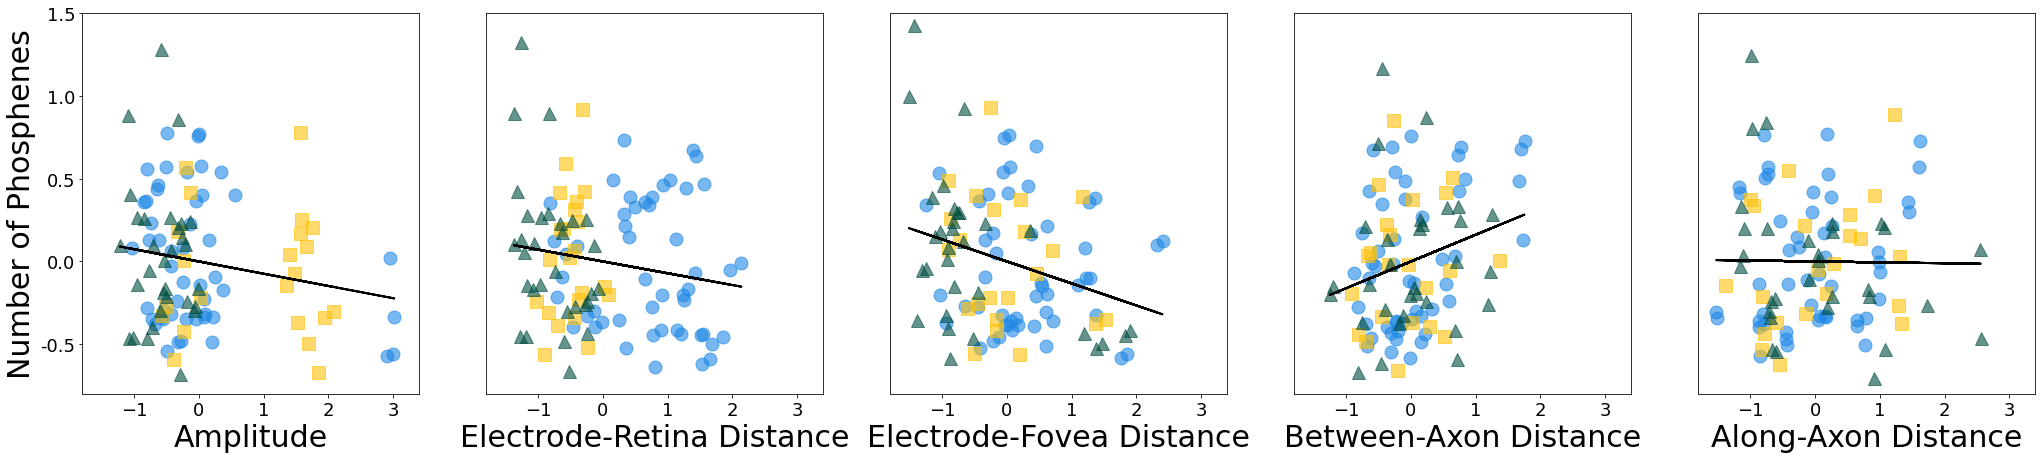

In [20]:
fig, axs= plt.subplots(ncols=5, figsize=(35, 7))
column_lst = ['amp','single_dti', 'single_dtf','across','along']
name_lst = ['Amplitude','Electrode-Retina Distance', 'Electrode-Fovea Distance','Between-Axon Distance','Along-Axon Distance']
for dv in range(5):
    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[['double']])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    y = df_AllSub[['double']]-y_predicted

    reg = LinearRegression().fit(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]], df_AllSub[column_lst[dv]])
    y_predicted = reg.predict(df_AllSub[column_lst[:dv] + column_lst[dv+1 :]])
    x = df_AllSub[column_lst[dv]]-y_predicted
    df_AllSub['x'] = x
    df_AllSub['y'] = y
    subject = ['12-005','51-009','52-001']
    marker_lst = ['o','s','^']
    color_lst = ['#1E88E5', '#FFC107','#004D40']
    for i in range(len(subject)):
        temp = df_AllSub[df_AllSub.subject == subject[i]]
        axs[dv].plot(temp['x'],temp['y'],marker_lst[i], color=color_lst[i],alpha=0.6,markersize=13)
    reg = LinearRegression().fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    y_pred = reg.predict(np.array(x).reshape(-1,1))
    axs[dv].plot(x, y_pred,'-', color="black",linewidth=2)
    axs[dv].set(xlabel = name_lst[dv],ylim=(-0.8,1.5),xlim=(-1.8,3.4))
    axs[0].set(ylabel = 'Number of Phosphenes')
    axs[dv].tick_params(axis='both',  labelsize=18)
    
    if dv>0:
        axs[dv].get_yaxis().set_visible(False)
    axs[dv].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    for item in ([axs[dv].xaxis.label, axs[dv].yaxis.label]):
        item.set_fontsize(30)
fig.savefig('/home/yuchen/paper/12f. Double-Electrode Number of Phosphenes.pdf', transparent=True)

In [ ]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == '12-005':
        X = temp[['amp','single_dtf','single_dti','across', 'along']]
    elif subj == 'AllSubjects':
        temp = df_AllSub.copy()
        X = temp[['amp','single_dtf','single_dti','across', 'along']]
    else:
        X = temp[['amp','single_dtf','across', 'along']]
    y = temp.double
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient')
    [ print(round(x,5), end='\n') for x in est2.params.tolist()[1:]]
    coef = [ round(x,5) for x in est2.params.tolist()[1:]]
    
    print('\npvalues')
    [ print(round(x,5), end='\n') for x in est2.pvalues.tolist()[1:]]
    p = [ round(x,5) for x in est2.pvalues.tolist()[1:]]
    
    print('\nvariance inflation factor: ')
    print([[X.columns[i],variance_inflation_factor(X.values, i)]
                          for i in range(len(X.columns))])
    print('\npartial correlation: ')
    X['double'] = temp['double']
    [print(round(X.pcorr()['double'][i].tolist(), 6), end='\n') for i in X.pcorr()[:-1]]
    pcor = [round(X.pcorr()['double'][i].tolist(), 6) for i in X.pcorr()[:-1]]
    
    print(' ')
    
    if subj == 'AllSubjects' or subj == '12-005':
        pcor[1],pcor[2] = pcor[2],pcor[1]
        coef[1],coef[2] = coef[2],coef[1]
        p[1],p[2] = p[2],p[1]
    
    for idx in range(len(p)):
        print('$', end = '')
        x = f'{coef[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        if p[idx]<0.001: print('***', end = ' ')
        elif p[idx]<0.01: print('**', end = ' ')
        elif p[idx]<0.05: print('*', end = ' ')
        else: print('', end = ' ')
        print('& $', end = '')
        x = f'{pcor[idx]:.3g}'
        if x[0] == str(0): print(x[1:], end='')
        elif float(x) < 0 and x[1] == str(0): print('-' + x[2:], end='')
        else: print(x, end='')
        for _ in range(5 - len(x)):
            print('0', end='')
        print('$', end = '')
        print()
    

## 2. pair_electrode shape = single_electrode shape + single_electrode shape

In [32]:
# calculate shapes 
data = shapes.load_shapes("/home/yuchen/shapes/data/shapes.h5", subjects=['12-005','51-009','52-001'],stim_class=None)


result = pd.DataFrame({})
for i in range(len(data)):
    label_img = skimage.measure.label(data['image'][i]>0)
    regions = regionprops(label_img)
    props = regionprops_table(label_img, properties=('centroid',
                                                     'orientation',
                                                     'major_axis_length',
                                                     'minor_axis_length',
                                                     'area',
                                                    'eccentricity',
                                                    'perimeter'))
    df = pd.DataFrame(props).astype('object')
    df.at[0,'centroid-0'] = df.iloc[:, 0].tolist()  # store centroid-x
    df.at[0,'centroid-1'] = df.iloc[:, 1].tolist()  # store centroid-y
    df.at[0,'orientation'] = df.iloc[:, 2].tolist()  # store orientation
    df.at[0,'major_axis_length'] = df.iloc[:, 3].tolist()  # major
    df.at[0,'minor_axis_length'] = df.iloc[:, 4].tolist()  # minor
    df.at[0,'area'] = df.iloc[:, 5].tolist()  # area
    df.at[0,'eccentricity'] = df.iloc[:, 6].tolist()  
    df.at[0,'perimeter'] = df.iloc[:, 7].tolist()  
    result = pd.concat([result, df.iloc[:1,:]],axis=0)

result = result.rename(columns={"area":"size", "orientation":"orientation_new", "eccentricity":"eccentricity_new" })
data = pd.concat([data,result.reset_index(drop=True)],axis=1)
data_copy = data.copy()

In [33]:
data = data_copy.copy()

data_double = data[(data['electrode2'] != str())].reset_index(drop=True)
data_single = data[(data['electrode2'] == str())].reset_index(drop=True)
data_single['stim_class'] ='SingleElectrode'
df = data_single[['subject', 'electrode1', 'freq', 'amp1']].drop_duplicates().reset_index(drop=True)
lst = []
lst_size = []
lst_major = []
lst_minor = []
lst_eccentricity = []
lst_orientation = []
lst_perimeter = []

for i in range(len(df)):
    df_temp = data_single[(data_single['subject'] == df.subject[i]) & (data_single['electrode1'] == df.electrode1[i]) & (data_single['freq'] == df.freq[i]) & (data_single['amp1'] == df.amp1[i])].reset_index(drop=True)
    ratio = len(df_temp[df_temp['num_regions']>1]) /len(df_temp)
    
    for row in range(len(df_temp)):
        df_temp['size'][row] = sum(df_temp['size'][row])
        df_temp['major_axis_length'][row] = sum(df_temp['major_axis_length'][row])
        df_temp['minor_axis_length'][row] = sum(df_temp['minor_axis_length'][row])
        df_temp['perimeter'][row] = sum(df_temp['perimeter'][row])
        df_temp['orientation_new'][row] = sum(df_temp['orientation_new'][row])
        
    
    count_length = len(df_temp)
    
    lst_size.append(df_temp['size'].sum()/count_length)
    lst_major.append(df_temp['major_axis_length'].sum()/count_length)
    lst_minor.append(df_temp['minor_axis_length'].sum()/count_length)
    lst_perimeter.append(df_temp['perimeter'].sum()/count_length)
    lst_orientation.append(df_temp['orientation_new'].sum()/count_length)
    
        
df['avg_size'] = lst_size
df['avg_major'] = lst_major
df['avg_minor'] = lst_minor
df['avg_perimeter'] = lst_perimeter
df['avg_orientation'] = lst_orientation


data_single = df.copy()

index_lst = []
for i in range(len(data_double)):
    if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode1[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
        if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode2[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
            index_lst.append(i)

In [34]:
subject = ['12-005','51-009','52-001']
df_dti = pd.DataFrame({})
for subj in subject:
    lst_e = []
    lst_dtf = []

    s = shapes.subject_params[subj]
    implant,model = shapes.model_from_params(s)
    for i in string.ascii_uppercase[0:6]: 
        for j in range(1,11):
            electrode = i + str(j)
            lst_e.append(electrode)
            lst_dtf.append(math.sqrt(implant[electrode].x**2 +implant[electrode].y**2 ))

    df_o = pd.DataFrame(lst_e, columns=['electrode1'])
    df_o['distance_to_fovea'] = lst_dtf

    if subj == '12-005':
        lst_d = [0,0,0,2,7,7,0,0,5,0,
                    0,0,4,11,13,15,15,3,7,4,
                    0,0,15,16,17,17,19,16,9,4,
                    0,0,16,19,15,17,22,25,13,10,
                    0,0,8,15,14,13,17,23,14,2,
                    0,0,10,15,13,12,9,11,5]
        lst_e = lst_e[:-1]
    elif subj == '51-009':
        lst_e = ['F1','F2','F3','F4','F5','F6',
               'E1','E2','E3','E4','E5','E6',
               'D1','D2','D3','D4','D5','D6','D7',
               'C1','C2','C3','C4','C5','C6','C7','C8',
               'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10', 
               'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        
        lst_d = [0] * len(lst_e)
    else:
        lst_e = ['F1','F2','F4','F5','F6','F7','F8','F9','F10',
                   'E1','E2','E3','E4','E5','E6','E7','E8','E9','E10', 
                   'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 
                   'C3','C4','C5','C6','C7','C8','C9','C10', 
                   'B1','B3','B4','B5','B6','B7','B8','B9','B10', 
                   'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        lst_d = [0] * len(lst_e)
    lst_s = [subj] * len(lst_e)

    df_o = df_o[df_o.electrode1.isin(lst_e)]
    df_o['distance_to_implant'] = lst_d
    df_o['subject'] = lst_s
    df_dti = pd.concat([df_dti, df_o])
df_dti = df_dti.reset_index(drop=True)

data_single = data_single.merge(df_dti, how = 'inner', on = ['electrode1','subject'])

### size

In [35]:
label_list = ['MultiElectrode']
for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)
    double = []
    single = []
    single1 = []
    single2 = []
    lst_subject = []
    electrode_pair = []
        
    distance = []
    distance_tan = []
    distance_per = []
    same_side = []   # check if both electrodes are at the same side of raphe, 1 for true, 0 for false
    within_range = []  # check if electrode is within 2mm of fovea, 1 for true, 0 for false
    between = []
    along = []
    amp = []
    freq = []
    electrode = []
    inside = []
    single_dti = []
    single_dtf=[]
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            count = 0
            for j in range(len(double_temp)):
                count += sum(double_temp['size'][j])
            double.append(count/len(double_temp))
            single.append(temp1.avg_size[0] + temp2.avg_size[0])
            single1.append(temp1.avg_size[0])
            single2.append(temp2.avg_size[0])
            
            lst_subject.append(temp1.subject[0])
                
            subject = shapes.subject_params[temp1.subject[0]]
            implant,model = shapes.model_from_params(subject)
                
            e1_x = implant[electrode1].x
            e1_y = implant[electrode1].y
            e2_x = implant[electrode2].x
            e2_y = implant[electrode2].y
            
            single_dti.append(mean([df_dti[(df_dti.electrode1 == lst.electrode1[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0], 
                                    df_dti[(df_dti.electrode1 == lst.electrode2[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0]]))
            
            
            distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
            single_dtf.append(mean([math.sqrt(e1_x**2 + e1_y**2), math.sqrt(e2_x**2 + e2_y**2)]))
            
            amp.append(lst.amp1[i])
            freq.append(lst.freq[i])
            electrode_pair.append(electrode1 + str('_') + electrode2)
    
    
    
    df_investigate = pd.DataFrame({    'single':single,
                                   'single1':single1,
                                   'single2':single2,
                                       'double':double, 
                                   'single_dti':single_dti,
                                   'single_dtf':single_dtf,

                                   'distance':distance,
                                   'electrode_pair':electrode_pair,
                                       'subject':lst_subject,
                                   'amp':amp,
                                   'freq':freq
                                      })

    temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) &
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
                          
    temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
    df = pd.DataFrame({})
    for subj in temp.subject:
        df_investigate_temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
        df_investigate_temp['single'] = df_investigate_temp['single'] / temp[temp.subject == subj].iloc[0]['single']
        df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['single']
        df = pd.concat([df, df_investigate_temp])
    df_investigate = df.copy()

In [36]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == 'AllSubjects':
        temp = df_investigate
    X = temp[['single']]
    y = temp.double
#     X2 = sm.add_constant(X)
#     est = sm.OLS(y, X2)
    est = sm.OLS(y, X)

    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient with more digits: ')
    print(est2.params)
    print('\npartial correlation: ')
    print(temp[['single','double']].pcorr())
    print(' ')

subject: 12-005
                                 OLS Regression Results                                
Dep. Variable:                 double   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              155.8
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                    4.01e-17
Time:                        18:16:58   Log-Likelihood:                         -38.370
No. Observations:                  52   AIC:                                      78.74
Df Residuals:                      51   BIC:                                      80.69
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### major

In [37]:
label_list = ['MultiElectrode']
for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)
    double = []
    single = []
    single1 = []
    single2 = []
    lst_subject = []
    electrode_pair = []
        
    distance = []
    distance_tan = []
    distance_per = []
    same_side = []   # check if both electrodes are at the same side of raphe, 1 for true, 0 for false
    within_range = []  # check if electrode is within 2mm of fovea, 1 for true, 0 for false
    between = []
    along = []
    amp = []
    freq = []
    electrode = []
    inside = []
    single_dti = []
    single_dtf=[]
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            count = 0
            for j in range(len(double_temp)):
                count += sum(double_temp['major_axis_length'][j])
            double.append(count/len(double_temp))

            single.append(temp1.avg_major[0] + temp2.avg_major[0])
            single1.append(temp1.avg_major[0])
            single2.append(temp2.avg_major[0])
            
            lst_subject.append(temp1.subject[0])
                
            subject = shapes.subject_params[temp1.subject[0]]
            implant,model = shapes.model_from_params(subject)
                
            e1_x = implant[electrode1].x
            e1_y = implant[electrode1].y
            e2_x = implant[electrode2].x
            e2_y = implant[electrode2].y
            
            single_dti.append(mean([df_dti[(df_dti.electrode1 == lst.electrode1[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0], 
                                    df_dti[(df_dti.electrode1 == lst.electrode2[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0]]))
            
            distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
            single_dtf.append(mean([math.sqrt(e1_x**2 + e1_y**2), math.sqrt(e2_x**2 + e2_y**2)]))
            
            amp.append(lst.amp1[i])
            freq.append(lst.freq[i])
            electrode_pair.append(electrode1 + '_' + electrode2)
    
    
    
    df_investigate = pd.DataFrame({    'single':single,
                                   'single1':single1,
                                   'single2':single2,
                                       'double':double, 
                                   'single_dti':single_dti,
                                   'single_dtf':single_dtf,

                                   'distance':distance,
                                   'electrode_pair':electrode_pair,
                                       'subject':lst_subject,
                                   'amp':amp,
                                   'freq':freq
                                      })

    temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) &
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]

    temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
    df = pd.DataFrame({})
    for subj in temp.subject:
        df_investigate_temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
        df_investigate_temp['single'] = df_investigate_temp['single'] / temp[temp.subject == subj].iloc[0]['single']
        df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['single']
        df = pd.concat([df, df_investigate_temp])
    df_investigate = df.copy()

In [38]:
name = 'major'
df_investigate[['single','double','single_dti','single_dtf','subject','electrode_pair','amp','freq']].to_csv('/home/yuchen/' + name + '.csv')

In [39]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == 'AllSubjects':
        temp = df_investigate
    X = temp[['single']]
    y = temp.double
    est = sm.OLS(y, X)
    
#     X2 = sm.add_constant(X)
#     est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient with more digits: ')
    print(est2.params)
    print('\npartial correlation: ')
    print(temp[['single','double']].pcorr())
    print(' ')

subject: 12-005
                                 OLS Regression Results                                
Dep. Variable:                 double   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              1217.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                    2.97e-37
Time:                        18:17:23   Log-Likelihood:                          62.039
No. Observations:                  52   AIC:                                     -122.1
Df Residuals:                      51   BIC:                                     -120.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### minor

In [40]:
label_list = ['MultiElectrode']
for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)
    double = []
    single = []
    single1 = []
    single2 = []
    lst_subject = []
    electrode_pair = []
        
    distance = []
    distance_tan = []
    distance_per = []
    same_side = []   # check if both electrodes are at the same side of raphe, 1 for true, 0 for false
    within_range = []  # check if electrode is within 2mm of fovea, 1 for true, 0 for false
    between = []
    along = []
    amp = []
    freq = []
    electrode = []
    inside = []
    single_dti = []
    single_dtf=[]
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            count = 0
            for j in range(len(double_temp)):
                count += sum(double_temp['minor_axis_length'][j])
            double.append(count/len(double_temp))
            single.append(temp1.avg_minor[0] + temp2.avg_minor[0])
            single1.append(temp1.avg_minor[0])
            single2.append(temp2.avg_minor[0])
            
            lst_subject.append(temp1.subject[0])
                
            subject = shapes.subject_params[temp1.subject[0]]
            implant,model = shapes.model_from_params(subject)
                
            e1_x = implant[electrode1].x
            e1_y = implant[electrode1].y
            e2_x = implant[electrode2].x
            e2_y = implant[electrode2].y
            
            amp.append(lst.amp1[i])
            freq.append(lst.freq[i])
            
            single_dti.append(mean([df_dti[(df_dti.electrode1 == lst.electrode1[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0], 
                                    df_dti[(df_dti.electrode1 == lst.electrode2[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0]]))
                
            
            distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
            single_dtf.append(mean([math.sqrt(e1_x**2 + e1_y**2), math.sqrt(e2_x**2 + e2_y**2)]))
            electrode_pair.append(electrode1 + str('_') + electrode2)
    
    df_investigate = pd.DataFrame({    'single':single,
                                   'single1':single1,
                                   'single2':single2,
                                       'double':double, 
                                   'single_dti':single_dti,
                                   'single_dtf':single_dtf,

                                   'distance':distance,
                                   'electrode_pair':electrode_pair,
                                       'subject':lst_subject,
                                   'amp':amp,
                                   'freq':freq
                                      })

    temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) &
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
#                           (df_investigate.single_dtf > 2500) & (df_investigate.single_dtf < 5000)]             
                          
    temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
    df = pd.DataFrame({})
    for subj in temp.subject:
        df_investigate_temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
        df_investigate_temp['single'] = df_investigate_temp['single'] / temp[temp.subject == subj].iloc[0]['single']
        df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['single']
        df = pd.concat([df, df_investigate_temp])
    df_investigate = df.copy()

In [139]:
name = 'minor'
df_investigate[['single','double','single_dti','single_dtf','electrode_pair','subject','amp','freq']].to_csv('/home/yuchen/' + name + '.csv')

In [41]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == 'AllSubjects':
        temp = df_investigate
    X = temp[['single']]
    y = temp.double
    est = sm.OLS(y, X)
#     X2 = sm.add_constant(X)
#     est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient with more digits: ')
    print(est2.params)
    print('\npartial correlation: ')
    print(temp[['single','double']].pcorr())
    print(' ')

subject: 12-005
                                 OLS Regression Results                                
Dep. Variable:                 double   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              502.6
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                    4.55e-28
Time:                        18:17:56   Log-Likelihood:                         -3.6627
No. Observations:                  52   AIC:                                      9.325
Df Residuals:                      51   BIC:                                      11.28
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### perimeter

In [42]:
label_list = ['MultiElectrode']
for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)
    double = []
    single = []
    single1 = []
    single2 = []
    lst_subject = []
    electrode_pair = []
    distance = []
    distance_tan = []
    distance_per = []
    between = []
    along = []
    same_side = []
    amp = []
    freq = []
    inside = []
    electrode = []
    single_dti = []
    single_dtf=[]
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            count = 0
            for j in range(len(double_temp)):
                count += sum(double_temp['perimeter'][j])
            double.append(count/len(double_temp))
            single.append(temp1.avg_perimeter[0] + temp2.avg_perimeter[0])
            single1.append(temp1.avg_perimeter[0])
            single2.append(temp2.avg_perimeter[0])
            
            lst_subject.append(temp1.subject[0])
                
            subject = shapes.subject_params[temp1.subject[0]]
            implant,model = shapes.model_from_params(subject)
                
            e1_x = implant[electrode1].x
            e1_y = implant[electrode1].y
            e2_x = implant[electrode2].x
            e2_y = implant[electrode2].y
                
            amp.append(lst.amp1[i])
            freq.append(lst.freq[i])
            
            electrode_pair.append(electrode1+'_'+electrode2)
            
            single_dti.append(mean([df_dti[(df_dti.electrode1 == lst.electrode1[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0], 
                                    df_dti[(df_dti.electrode1 == lst.electrode2[i]) & 
                                           (df_dti.subject == lst.subject[i])].distance_to_implant.tolist()[0]]))
                
            
            distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
            single_dtf.append(mean([math.sqrt(e1_x**2 + e1_y**2), math.sqrt(e2_x**2 + e2_y**2)]))
    
    
    df_investigate = pd.DataFrame({    'single':single,
                                   'single1':single1,
                                   'single2':single2,
                                       'double':double, 
                                   'single_dti':single_dti,
                                   'single_dtf':single_dtf,
                                   'electrode_pair':electrode_pair,

                                   'distance':distance,
                                       'subject':lst_subject,
                                   'amp':amp,
                                   'freq':freq
                                      })

    temp = df_investigate[(df_investigate.amp == 2) & (df_investigate.freq == 20) & 
                              (df_investigate.single_dti == 0) &
                              (df_investigate.single_dtf > 2950) & (df_investigate.single_dtf < 3450)]
#                           (df_investigate.single_dtf > 2500) & (df_investigate.single_dtf < 5000)]             
                       
    temp = temp.groupby(['amp','freq','subject']).mean().reset_index()
    df = pd.DataFrame({})
    for subj in temp.subject:
        df_investigate_temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
        df_investigate_temp['single'] = df_investigate_temp['single'] / temp[temp.subject == subj].iloc[0]['single']
        df_investigate_temp['double'] = df_investigate_temp['double'] / temp[temp.subject == subj].iloc[0]['single']
        df = pd.concat([df, df_investigate_temp])
    df_investigate = df.copy()

In [142]:
name = 'perimeter'
df_investigate[['single','double','single_dti','single_dtf','electrode_pair','subject','amp','freq']].to_csv('/home/yuchen/' + name + '.csv')

In [43]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == 'AllSubjects':
        temp = df_investigate
    X = temp[['single']]
    y = temp.double
    est = sm.OLS(y, X)
#     X2 = sm.add_constant(X)
#     est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient with more digits: ')
    print(est2.params)
    print('\npartial correlation: ')
    print(temp[['single','double']].pcorr())
    print(' ')

subject: 12-005
                                 OLS Regression Results                                
Dep. Variable:                 double   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              1445.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                    4.34e-39
Time:                        18:18:18   Log-Likelihood:                          55.721
No. Observations:                  52   AIC:                                     -109.4
Df Residuals:                      51   BIC:                                     -107.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### orientation

In [10]:
label_list = ['MultiElectrode']
for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)
    double = []
    single = []
    single1 = []
    single2 = []
    lst_subject = []
    between = []
    along = []
    distance = []
    distance_tan = []
    distance_per = []
    same_side = []
    inside = []
    amp = []
    freq = []
    electrode = []
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            count = 0
            for j in range(len(double_temp)):
                count += mean(double_temp['orientation_new'][j])
            double.append(count/len(double_temp))
            single.append(mean([temp1.avg_orientation[0], temp2.avg_orientation[0]]))
            single1.append(temp1.avg_orientation[0])
            single2.append(temp2.avg_orientation[0])
            
            lst_subject.append(temp1.subject[0])
                
            subject = shapes.subject_params[temp1.subject[0]]
            implant,model = shapes.model_from_params(subject)
                
            e1_x = implant[electrode1].x
            e1_y = implant[electrode1].y
            e2_x = implant[electrode2].x
            e2_y = implant[electrode2].y

            distance.append(math.sqrt((e1_x - e2_x)**2 + (e1_y - e2_y)**2))
            
            amp.append(lst.amp1[i])
            freq.append(lst.freq[i])

    df_investigate = pd.DataFrame({    'single':single,
                                   'single1':single1,
                                   'single2':single2,
                                       'double':double, 
                                   'distance':distance,
                                       'subject':lst_subject,
                                   'amp':amp,
                                   'freq':freq
                                      })
    for subj in ['12-005', '51-009', '52-001']:
        df_investigate_temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
        filename = subj + label_list[label] 
        df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
    filename = label_list[label]
    df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

In [12]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == 'AllSubjects':
        temp = df_investigate
    X = temp[['single']]
    y = temp.double
    est = sm.OLS(y, X)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient with more digits: ')
    print(est2.params)
    print('\npartial correlation: ')
    print(temp[['single','double']].pcorr())
    print(' ')

subject: 12-005
                                 OLS Regression Results                                
Dep. Variable:                 double   R-squared (uncentered):                   0.436
Model:                            OLS   Adj. R-squared (uncentered):              0.425
Method:                 Least Squares   F-statistic:                              39.44
Date:                Thu, 15 Jun 2023   Prob (F-statistic):                    7.46e-08
Time:                        14:19:32   Log-Likelihood:                         -36.743
No. Observations:                  52   AIC:                                      75.49
Df Residuals:                      51   BIC:                                      77.44
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

### phosphene number 

In [118]:
data = data_copy.copy()

data_double = data[(data['electrode2'] != str())].reset_index(drop=True)
data_single = data[(data['electrode2'] == str())].reset_index(drop=True)


subject = ['12-005','51-009','52-001']
df_dti = pd.DataFrame({})
for subj in subject:
    lst_e = []
    lst_dtf = []

    s = shapes.subject_params[subj]
    implant,model = shapes.model_from_params(s)
    for i in string.ascii_uppercase[0:6]: 
        for j in range(1,11):
            electrode = i + str(j)
            lst_e.append(electrode)
            lst_dtf.append(math.sqrt(implant[electrode].x**2 +implant[electrode].y**2 ))

    df_o = pd.DataFrame(lst_e, columns=['electrode1'])
    df_o['distance_to_fovea'] = lst_dtf

    if subj == '12-005':
        lst_d = [0,0,0,2,7,7,0,0,5,0,
                    0,0,4,11,13,15,15,3,7,4,
                    0,0,15,16,17,17,19,16,9,4,
                    0,0,16,19,15,17,22,25,13,10,
                    0,0,8,15,14,13,17,23,14,2,
                    0,0,10,15,13,12,9,11,5]
        lst_e = lst_e[:-1]
    elif subj == '51-009':
        lst_e = ['F1','F2','F3','F4','F5','F6',
               'E1','E2','E3','E4','E5','E6',
               'D1','D2','D3','D4','D5','D6','D7',
               'C1','C2','C3','C4','C5','C6','C7','C8',
               'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10', 
               'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        
        lst_d = [0] * len(lst_e)
    else:
        lst_e = ['F1','F2','F4','F5','F6','F7','F8','F9','F10',
                   'E1','E2','E3','E4','E5','E6','E7','E8','E9','E10', 
                   'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 
                   'C3','C4','C5','C6','C7','C8','C9','C10', 
                   'B1','B3','B4','B5','B6','B7','B8','B9','B10', 
                   'A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
        lst_d = [0] * len(lst_e)
    lst_s = [subj] * len(lst_e)

    df_o = df_o[df_o.electrode1.isin(lst_e)]
    df_o['distance_to_implant'] = lst_d
    df_o['subject'] = lst_s
    df_dti = pd.concat([df_dti, df_o])
df_dti = df_dti.reset_index(drop=True)

data_single = data_single.merge(df_dti, how = 'inner', on = ['electrode1','subject'])

In [119]:
data_single['stim_class'] ='SingleElectrode'
df = data_single[['subject', 'electrode1', 'freq', 'amp1']].drop_duplicates().reset_index(drop=True)

lst = []
lst_phosphene = []

for i in range(len(df)):
    df_temp = data_single[(data_single['subject'] == df.subject[i]) & (data_single['electrode1'] == df.electrode1[i]) & (data_single['freq'] == df.freq[i]) & (data_single['amp1'] == df.amp1[i])].reset_index(drop=True)
    ratio = len(df_temp[df_temp['num_regions']>1]) /len(df_temp)
    lst.append(ratio)
    lst_phosphene.append(mean(df_temp['num_regions']))
        
df['phosphene'] = lst_phosphene

data_single = df


index_lst = []
for i in range(len(data_double)):
    if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode1[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
        if not (data_single[(data_single['subject'] == data_double.subject[i]) & (data_single['electrode1'] == data_double.electrode2[i]) & (data_single['freq'] == data_double.freq[i]) & (data_single['amp1'] == data_double.amp1[i])].empty):
            index_lst.append(i)
            
label_list = ['MultiElectrode']

for label in range(1):
    data_double_temp = data_double.iloc[index_lst].reset_index(drop=True)
    data_double_temp = data_double_temp[data_double_temp['stim_class'] == label_list[label]]
    lst = data_double_temp[['electrode1','electrode2','amp1','freq','subject']]
    lst = lst.drop_duplicates().reset_index(drop=True)

    double = []
    single = []
    single1 = []
    single2 = []
    electrode_pair = []

    lst_subject = []
    distance = []
    electrode = []

    amp = []
    freq = []
    inside = []
    for i in range(len(lst)):
        electrode1 = lst.electrode1[i]
        electrode2 = lst.electrode2[i]
        temp1 = data_single[(data_single['electrode1'] == electrode1) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        temp2 = data_single[(data_single['electrode1'] == electrode2) &  (data_single['subject'] == lst.subject[i])  & (data_single['amp1'] == lst.amp1[i]) & (data_single['freq'] == lst.freq[i])].reset_index(drop=True)
        double_temp = data_double_temp[(data_double_temp['electrode1'] == electrode1) & ((data_double_temp['electrode2'] == electrode2))& (data_double_temp['subject'] == lst.subject[i]) & (data_double_temp['amp1'] == lst.amp1[i]) & (data_double_temp['freq'] == lst.freq[i])].reset_index(drop=True)
        if not temp1.empty and not temp2.empty and not double_temp.empty:
            count = 0
            for j in range(len(double_temp)):
                count += double_temp['num_regions'][j]
            double.append(count/len(double_temp))
            single.append(sum([temp1.phosphene[0], temp2.phosphene[0]]))
            single1.append(temp1.phosphene[0])
            single2.append(temp2.phosphene[0])
            
            lst_subject.append(temp1.subject[0])
                
            subject = shapes.subject_params[temp1.subject[0]]
            implant,model = shapes.model_from_params(subject)
            
            amp.append(lst.amp1[i])
            freq.append(lst.freq[i])
            electrode_pair.append(electrode1+'_'+electrode2)

    df_investigate = pd.DataFrame({    'single':single,
                                   'single1':single1,
                                   'single2':single2,
                                       'double':double, 

                                       'subject':lst_subject,
                                   'electrode_pair':electrode_pair,
                                   'amp':amp,
                                   'freq':freq
                                      })
    for subj in ['12-005', '51-009', '52-001']:
        df_investigate_temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
        filename = subj + label_list[label] 
        df_investigate_temp.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')
    filename = label_list[label]
    df_investigate.to_csv('/home/yuchen/shapes/notebooks/' + filename + '.csv')

In [120]:
name = 'phos_num'
df_investigate[['single','double','subject','electrode_pair','amp','freq']].to_csv('/home/yuchen/' + name + '.csv')

In [91]:
for subj in ['12-005','51-009','52-001','AllSubjects']:
    temp = df_investigate[df_investigate.subject == subj].reset_index(drop=True)
    if subj == 'AllSubjects':
        temp = df_investigate
    X = temp[['single']]
    y = temp.double
    est = sm.OLS(y, X)
#     X2 = sm.add_constant(X)
#     est = sm.OLS(y, X2)
    est2 = est.fit()
    print('subject: ' + subj)
    print(est2.summary())
    print('\ncoefficient with more digits: ')
    print(est2.params)
    print('\npartial correlation: ')
    print(temp[['single','double']].corr())
    print(' ')

subject: 12-005
                                 OLS Regression Results                                
Dep. Variable:                 double   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              672.0
Date:                Tue, 30 May 2023   Prob (F-statistic):                    4.97e-31
Time:                        15:50:59   Log-Likelihood:                         -25.624
No. Observations:                  52   AIC:                                      53.25
Df Residuals:                      51   BIC:                                      55.20
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------